## Tutorial on how to simulate an Isopycnal float in Parcels

This notebook shows how you can mimic the behavior of Argo floats and of an Isopycnal following float in OceanParcels.  The MUST MRV floats use a combination of these two float behaviors, with a depth-stepped profile from surface to 1000 followed by an isopycnal following phase followed by another profile to 1000 and then back to the surface to repeat the cycle.

In [13]:
# Define the new Kernel that mimics Argo vertical movement (from OceanParcels Tutorials)
def ArgoVerticalMovement(particle, fieldset, time):
    driftdepth = 1000  # maximum depth in m
    maxdepth = 2000  # maximum depth in m
    vertical_speed = 0.1  # sink and rise speed in m/s
    cycletime = 10 * 86400  # total time of cycle in seconds
    drifttime = 1 * 86400  # time of deep drift in seconds
    
    
    if particle.cycle_phase == 0:
        # Phase 0: Sinking with vertical_speed until depth is driftdepth
        particle.depth += vertical_speed * particle.dt
        if particle.depth >= driftdepth:
            particle.cycle_phase = 1

    elif particle.cycle_phase == 1:
        # Phase 1: Drifting at depth for drifttime seconds
        particle.drift_age += particle.dt
        if particle.drift_age >= drifttime:
            particle.drift_age = 0  # reset drift_age for next cycle
            particle.cycle_phase = 2

    elif particle.cycle_phase == 2:
        # Phase 2: Sinking further to maxdepth
        particle.depth += vertical_speed * particle.dt
        if particle.depth >= maxdepth:
            particle.cycle_phase = 3

    elif particle.cycle_phase == 3:
        # Phase 3: Rising with vertical_speed until at surface
        particle.depth -= vertical_speed * particle.dt
        if particle.depth <= fieldset.mindepth:
            particle.depth = fieldset.mindepth
            particle.cycle_phase = 4

    elif particle.cycle_phase == 4:
        # Phase 4: Transmitting at surface until cycletime is reached
        if particle.cycle_age > cycletime:
            particle.cycle_phase = 0
            particle.cycle_age = 0

    if particle.state == ErrorCode.Evaluate:
        particle.cycle_age += particle.dt  # update cycle_age
        
    # set particle density at new depth
    particle.rho =  fieldset.rho[time, particle.depth, particle.lat, particle.lon]

In [14]:
# Isopycnal Float set to Float at particle.float_density
# We use a crude dynamical approach where the float is assumed to be at equilibrium settling/rising velocity based on
# buoyancy and a drag coefficient derived from float geometry that is not Reynolds-dependent
# Need to handle the case where the float settles to the bottom - perhaps utilize rho=NaN and decide the implications
# Perhaps we need an additional flag for the case where we have bottom settling or where the set float density 
# Is not within the range of the density in the water column.  We can add that flag to the output
def IsoPycnalVerticalMovement(particle, fieldset, time):
    Cd = 0.5                       #drag coefficient [-]
    Rad = 0.5                      #float radius [m]
    g = 9.81                       #gravitational acceleration [ms^-2]
    Vol = (4./3.)*math.pi*(Rad**3) #float volume [m^3]
    Ax = math.pi*(Rad**2)          #float x-section area [m^2]
 
 
    # set local density at current particle position for computing buoyant force
    local_rho =  fieldset.rho[time, particle.depth, particle.lat, particle.lon]
 
    # compute the terminal velocity
    buoyant_force = (local_rho-particle.float_density)*g*Vol
    if buoyant_force > 0:
        sink_speed = -math.sqrt((buoyant_force)/(.5*local_rho*Cd*Ax))
    else:
        sink_speed = math.sqrt(-(buoyant_force)/(.5*local_rho*Cd*Ax))
    
    # move particle to new depth based on terminal velocity and time step
    particle.depth += sink_speed * particle.dt
    
    # store vertical speed for output
    particle.w = sink_speed
    
    # allow float to float at the surface if float_density < surface_density
    if particle.depth < 0:
        particle.depth = 0
        particle.w = 0
    
    # set particle density at new depth for output
    particle.rho =  fieldset.rho[time, particle.depth, particle.lat, particle.lon]
    
    # store for debugging
    particle.tmp1 = buoyant_force
  

Run OceanParcels with the Custom Isopycnal Kernal.  Thus horizontal advection (and updated position) will be handled by OceanParcels and Vertical Position by the IsoPycnalVerticalMovement routine. 

In [15]:
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, ErrorCode, Variable
from datetime import timedelta, datetime
import numpy as np


# Load the HYCOM Analysis data in the Gulf of Maine
# The paths/datafiles should be read in from a control file
filenames = {'U': "./hycom_data/*.nc",
             'V': "./hycom_data/*.nc",
             'rho': "./hycom_data/*.nc"}
variables = {'U': 'water_u',
             'V': 'water_v',
             'rho': 'rho'}
dimensions = {'lat': 'lat', 'lon': 'lon', 'depth' : 'depth' , 'time': 'time'}
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)#,allow_time_extrapolation = True)
fieldset.mindepth = fieldset.U.depth[0]  # uppermost layer in the hydrodynamic data

# print the domain boundaries to the screen
print(fieldset.U.lon[0],fieldset.U.lon[-1],fieldset.U.lat[0],fieldset.U.lat[-1])


# Define a new Particle type including extra Variables
class ArgoParticle(JITParticle):
    # Phase of cycle: init_descend=0, drift=1, profile_descend=2, profile_ascend=3, transmit=4
    cycle_phase = Variable('cycle_phase', dtype=np.int32, initial=0.)
    cycle_age = Variable('cycle_age', dtype=np.float32, initial=0.)
    drift_age = Variable('drift_age', dtype=np.float32, initial=0.)
    rho = Variable('rho', dtype=np.float32, initial=np.nan)  # store density
    
# Define a new Particle type including extra Variables
class IsoPycnalParticle(JITParticle):
    # Phase of cycle: init_descend=0, drift=1, profile_descend=2, profile_ascend=3, transmit=4
    float_density = Variable('float_density', dtype=np.float32, initial=1028.) #float programmed density
    rho = Variable('rho', dtype=np.float32, initial=np.nan)  # store density
    w   = Variable('w', dtype=np.float32, initial=np.nan)  # store vertical velocity
    tmp1 = Variable('tmp1', dtype=np.float32, initial=np.nan)  # store debugging var

# Initiate two Isopycnal Floats with staggered starts and different programmed drift densities initiated from 
# different depths and horizontal locations.  These variables here (lon, lat, time, float_density) should
# be read in from a control file.
pset = ParticleSet.from_list(fieldset=fieldset,
                            pclass=IsoPycnalParticle,
                            lon=[-69.5,-69.45],
                            lat=[43.25,43.3],
                            depth=[0,3000],
                            time=[datetime(2016, 1, 1),
                            datetime(2016,1,2,0,0,0)],
                            float_density=[1028.,1030.])


# combine Argo vertical movement kernel with built-in Advection kernel
#kernels = ArgoVerticalMovement + pset.Kernel(AdvectionRK4)
kernels = IsoPycnalVerticalMovement + pset.Kernel(AdvectionRK4)

# Create a ParticleFile object to store the output
# outputdt might be read in from a control file
output_file = pset.ParticleFile(name="float_output/isopycnal_float", outputdt=timedelta(minutes=30))

# Now execute the kernels for 30 days, saving data every 30 minutes
# dt and runtime might be read in from a control file
pset.execute(kernels, runtime=timedelta(days=2), dt=timedelta(minutes=1), output_file=output_file)

-70.0 -69.03998 43.0 43.52


Exception ignored in: <function ParticleFile.__del__ at 0x7f9b6c491dd0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/parcels/particlefile.py", line 189, in __del__
    self.close()
  File "/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/parcels/particlefile.py", line 194, in close
    self.export()
  File "/opt/anaconda3/envs/py3_parcels/lib/python3.7/site-packages/parcels/particlefile.py", line 296, in export
    raise RuntimeError("No npy files found in %s" % self.tempwritedir_base)
RuntimeError: No npy files found in float_output/out-YKLIVPWU
INFO: Compiled IsoPycnalParticleIsoPycnalVerticalMovementAdvectionRK4 ==> /var/folders/dz/bbfjw1hj3jd7hlf7hwmq0k1sqxddt7/T/parcels-1876342599/df8ef88f8cc26e89bef423d6554bfd7b_0.so


Now we can plot the trajectory of the Isopycnal float with some simple calls to netCDF4 and matplotlib

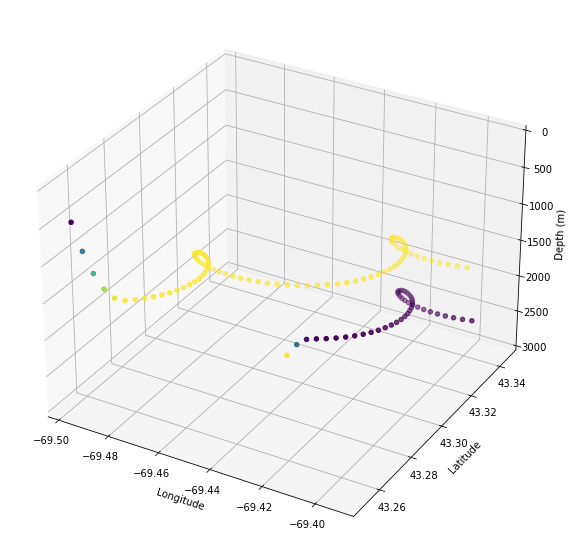

Text(0, 0.5, 'Density [kgm^-3]')

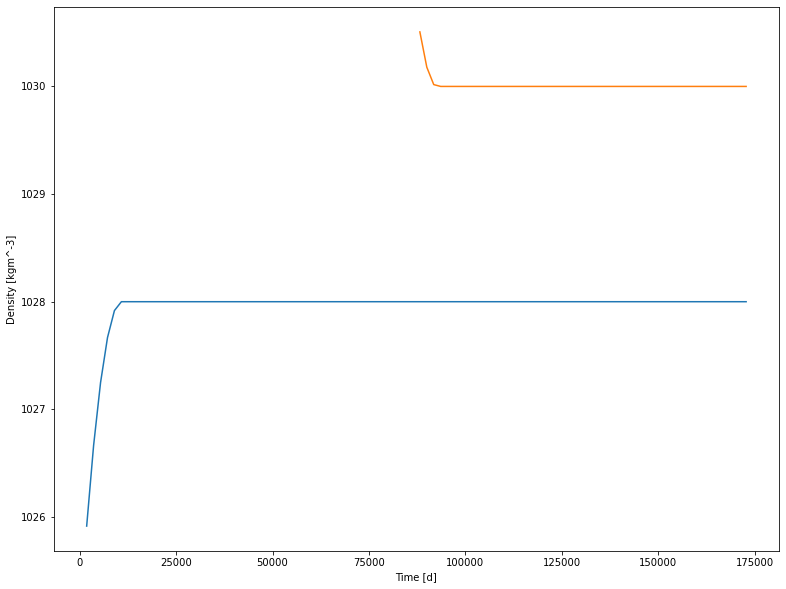

In [16]:
%matplotlib inline
#uncomment below for interactive plots (need ipympl)
####%matplotlib widget
import netCDF4
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


output_file.export()  # export the trajectory data to a netcdf file

nc = netCDF4.Dataset("float_output/isopycnal_float.nc")
x = nc.variables["lon"][:].squeeze()
time = nc.variables["time"][:].squeeze()
y = nc.variables["lat"][:].squeeze()
z = nc.variables["z"][:].squeeze()
rho = nc.variables["rho"][:].squeeze()
nc.close()


# 3D plot
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
for p in range(x.shape[0]):
    cb = ax.scatter(x[p,:], y[p,:], z[p,:], c=rho[p,:], s=20, marker="o")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z),0)
plt.show()

# time plot
fig = plt.figure(figsize=(13,10))
ax2 = plt.axes()
for p in range(x.shape[0]):
    plt.plot(time[p,:], rho[p,:])
ax2.set_xlabel("Time [d]")
ax2.set_ylabel("Density [kgm^-3]")

